In [1]:
# 구글 드라이버 이용
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#필요 라이브러리 임포트
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action='ignore')
plt.rcParams['axes.unicode_minus'] = False
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

In [0]:
# 파일 불러오기 예시
# pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/train.csv')

# 4319
train_dt = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/train.csv').set_index('id')
test_dt = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/test.csv').set_index('id')

### 분석 방법

1. Y00 - Y17 4300개의 데이터로 각 feature 430개의 값을 예측 
    - Y18 값과 유사한 feature 찾기
    - Y06,Y09,Y12,Y16이 Y18과의 mse값이 낮고, 상관도가 높다.

2. Y06,Y09,Y12,Y16의 조합으로 진짜 Y18을 예측
    - mse가 가장 낮은 조합을 사용

3.  Y_train 값 설정
  - 2번의 조합 + 기존의 Y18로 나머지 test 예측
  - 2번의 조합에서 각각의 Y로 80일 예측 후 평균

4. feature 공학

In [0]:
def predict_test(X_train, y_train, X_test):

  lgb_train = lgb.Dataset(X_train, label=y_train)

  lgb_param = {
      "objective":"regression",
      "metrics":"mae",
      "learning_rate":0.05
  }

  print("cv start")
  cv_result = lgb.cv(
      lgb_param,
      lgb_train,
      num_boost_round=99999,
      nfold=5,
      early_stopping_rounds=100,
      stratified=False,
      verbose_eval=10 
  )

  print("train start")
  lgb_model = lgb.train(
      lgb_param,
      lgb_train,
      num_boost_round=len(cv_result["l1-mean"])
  )

  pred = lgb_model.predict(X_test)

  feature_importance = pd.DataFrame({'name' : lgb_model.feature_name(),
                                   'importance' : lgb_model.feature_importance()})\
                                   .sort_values(by = 'importance', ascending = False)
  
  return pred, feature_importance

In [0]:
X_train = train_dt.iloc[:4320, :40]
X_test = train_dt.iloc[4320:, :40]
X = train_dt.iloc[:, :40]
Y_train = train_dt.loc[:4319, ['Y06', 'Y09', 'Y12']].mean(axis = 1)
Y_test = train_dt.loc[4320:, ['Y18']]

In [65]:
# data_processing_lst = []
# data_processing_lst 불러오기
data_processing_lst = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/data_processing_lst.csv').values.tolist()
data_processing_lst

[['All_feature_MinMaxScaler', 2913.177659654833],
 ['raw', 2925.955349543083],
 ['All_feature_MaxAbsScaler', 2925.955349543083],
 ['All_feature_LogScaler', 2926.503154744445],
 ['All_feature_RobustScaler', 2987.5879537738165],
 ['All_feature_StandardScaler', 2991.0399273592907]]

In [0]:
# # raw
# Y_pred = predict_test(X_train, Y_train, X_test)

In [0]:
# Y_test.index = range(len(Y_pred))
# plt.plot(Y_pred)
# plt.plot(Y_test['Y18'])
# mse1 = ((Y_pred - np.array(Y_test['Y18']))**2).sum()
# data_processing_lst.append(['raw',mse1])
# print(mse1)

In [0]:
# from sklearn.preprocessing import StandardScaler

# def data_processing1(X_data):
#   scaler = StandardScaler()
#   X_data[:] = scaler.fit_transform(X_data[:])
#   return X_data

# new_X = data_processing1(X.copy())
# X_train = new_X.iloc[:4320, :40]
# X_test = new_X.iloc[4320:, :40]
# Y_pred = predict_test(X_train, Y_train, X_test)

In [0]:
# Y_test.index = range(len(Y_pred))
# plt.plot(Y_pred)
# plt.plot(Y_test['Y18'])
# mse = ((Y_pred - np.array(Y_test['Y18']))**2).sum()
# data_processing_lst.append(['All_feature_StandardScaler',mse])
# print(mse)

In [0]:
# from sklearn.preprocessing import MinMaxScaler

# def data_processing1(X_data):
#   scaler = MinMaxScaler()
#   X_data[:] = scaler.fit_transform(X_data[:])
#   return X_data

# new_X = data_processing1(X.copy())
# X_train = new_X.iloc[:4320, :40]
# X_test = new_X.iloc[4320:, :40]
# Y_pred = predict_test(X_train, Y_train, X_test)

In [0]:
# Y_test.index = range(len(Y_pred))
# plt.plot(Y_pred)
# plt.plot(Y_test['Y18'])
# mse = ((Y_pred - np.array(Y_test['Y18']))**2).sum()
# data_processing_lst.append(['All_feature_MinMaxScaler',mse])
# print(mse)

In [0]:
# from sklearn.preprocessing import RobustScaler

# def data_processing1(X_data):
#   scaler = RobustScaler()
#   X_data[:] = scaler.fit_transform(X_data[:])
#   return X_data

# new_X = data_processing1(X.copy())
# X_train = new_X.iloc[:4320, :40]
# X_test = new_X.iloc[4320:, :40]
# Y_pred = predict_test(X_train, Y_train, X_test)

In [0]:
# Y_test.index = range(len(Y_pred))
# plt.plot(Y_pred)
# plt.plot(Y_test['Y18'])
# mse = ((Y_pred - np.array(Y_test['Y18']))**2).sum()
# data_processing_lst.append(['All_feature_RobustScaler',mse])
# print(mse)

In [0]:
# from sklearn.preprocessing import MaxAbsScaler

# def data_processing1(X_data):
#   scaler = MaxAbsScaler()
#   X_data[:] = scaler.fit_transform(X_data[:])
#   return X_data

# new_X = data_processing1(X.copy())
# X_train = new_X.iloc[:4320, :40]
# X_test = new_X.iloc[4320:, :40]
# Y_pred = predict_test(X_train, Y_train, X_test)

In [0]:
# Y_test.index = range(len(Y_pred))
# plt.plot(Y_pred)
# plt.plot(Y_test['Y18'])
# mse = ((Y_pred - np.array(Y_test['Y18']))**2).sum()
# data_processing_lst.append(['All_feature_MaxAbsScaler',mse])
# print(mse)

In [0]:
# from sklearn.preprocessing import FunctionTransformer

# def data_processing1(X_data):
#   scaler = FunctionTransformer(np.log1p, validate=True)
#   X_data[:] = scaler.fit_transform(X_data[:])
#   return X_data

# new_X = data_processing1(X.copy())
# X_train = new_X.iloc[:4320, :40]
# X_test = new_X.iloc[4320:, :40]
# Y_pred = predict_test(X_train, Y_train, X_test)

In [0]:
# Y_test.index = range(len(Y_pred))
# plt.plot(Y_pred)
# plt.plot(Y_test['Y18'])
# mse = ((Y_pred - np.array(Y_test['Y18']))**2).sum()
# data_processing_lst.append(['All_feature_LogScaler',mse])
# print(mse)

In [0]:
# from sklearn.preprocessing import FunctionTransformer

# def data_processing1(X_data):
#   # 0값인 feature 삭제
#   X_data = X_data.drop(['X14','X16','X19'], axis = 1)
#   scaler = FunctionTransformer(np.log1p, validate = True)
#   # raw에서 풍향이 중요한 feature로 나왔기 때문에 log로 scailing
#   X_data[['X13','X15','X17','X25','X35']] = scaler.fit_transform(X_data[['X13','X15','X17','X25','X35']])
  
#   return X_data

# new_X = data_processing1(X.copy())
# X_train = new_X.iloc[:4320, :40]
# X_test = new_X.iloc[4320:, :40]
# Y_pred, feature_importance = predict_test(X_train, Y_train, X_test)

In [0]:
# Y_test.index = range(len(Y_pred))
# plt.plot(Y_pred)
# plt.plot(Y_test['Y18'])
# mse = ((Y_pred - np.array(Y_test['Y18']))**2).sum()
# data_processing_lst.append(['Drop_14_16_19_log_wind_direction',mse])
# print(mse)
# print(feature_importance)

In [0]:
from sklearn.preprocessing import FunctionTransformer

# lightgbm이므로 scaling이 의미가 없다.
def Sectioning_daily_cumulative_precipitation(data):
  if data > 20: return 6
  elif data > 10: return 5
  elif data > 7: return 4
  elif data > 5: return 3
  elif data > 3: return 2
  elif data > 1: return 1
  elif data > 0: return 0.5
  else: return 0

def data_processing1(X_data):
  # 일일누적강수량 평균, 범주형
  X_data['Mean_daily_cumulative_precipitation'] = X_data[['X04','X10','X21','X36','X39']].mean(axis = 1)
  X_data['Sectioning_daily_cumulative_precipitation'] = X_data['Mean_daily_cumulative_precipitation'].apply(Sectioning_daily_cumulative_precipitation)

  # 0값인 feature 삭제
  X_data = X_data.drop(['X14','X16','X19'], axis = 1)
  # 누적 강수량 삭제
  X_data = X_data.drop(['X04','X10','X21','X36','X39'], axis = 1)

  return X_data

new_X = data_processing1(X.copy())
X_train = new_X.iloc[:4320, :40]
X_test = new_X.iloc[4320:, :40]
Y_pred, feature_importance = predict_test(X_train, Y_train, X_test)

2641.6659508828625
                                         name  importance
11                                        X13        7554
29                                        X35        7422
12                                        X15        6918
10                                        X12        5943
13                                        X17        5897
24                                        X30        5861
2                                         X02        5375
3                                         X03        5165
26                                        X32        5133
30                                        X37        5117
25                                        X31        5096
31                                        X38        5051
15                                        X20        4983
0                                         X00        4917
14                                        X18        4640
20                                        X26        

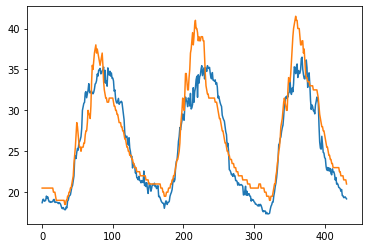

In [106]:
Y_test.index = range(len(Y_pred))
plt.plot(Y_pred)
plt.plot(Y_test['Y18'])
mse = ((Y_pred - np.array(Y_test['Y18']))**2).sum()
data_processing_lst.append(['Drop_0_value_and_daily_cumulative_precipitation_Mean_Sectioning_daily_cumulative_precipitation',mse])
print(mse)
print(feature_importance)

In [107]:
result = pd.DataFrame(data_processing_lst, columns = ['name','mse']).set_index('name').sort_values('mse')
result.to_csv('/content/gdrive/My Drive/Colab Notebooks/data_processing_lst.csv')
result

,mse
name,
Drop_0_value_and_daily_cumulative_precipitation_Mean_Sectioning_daily_cumulative_precipitation,2641.665951
All_feature_MinMaxScaler,2913.177660
Drop_14_16_19_daily_Sectioning_daily_cumulative_precipitation,2924.921363
raw,2925.955350
All_feature_MaxAbsScaler,2925.955350
Drop_14_16_19_log_wind_direction,2926.223459
All_feature_LogScaler,2926.503155
All_feature_RobustScaler,2987.587954
All_feature_StandardScaler,2991.039927


In [0]:
def Sectioning_daily_cumulative_precipitation(data):
  if data > 20: return 6
  elif data > 10: return 5
  elif data > 7: return 4
  elif data > 5: return 3
  elif data > 3: return 2
  elif data > 1: return 1
  elif data > 0: return 0.5
  else: return 0

def data_processing1(X_data):
  # 일일누적강수량 평균, 범주형
  X_data['Mean_daily_cumulative_precipitation'] = X_data[['X04','X10','X21','X36','X39']].mean(axis = 1)
  X_data['Sectioning_daily_cumulative_precipitation'] = X_data['Mean_daily_cumulative_precipitation'].apply(Sectioning_daily_cumulative_precipitation)

  # 0값인 feature 삭제
  X_data = X_data.drop(['X14','X16','X19'], axis = 1)
  # 누적 강수량 삭제
  X_data = X_data.drop(['X04','X10','X21','X36','X39'], axis = 1)

  return X_data

In [0]:
def Sectioning_daily_cumulative_precipitation(data):
  if data > 20: return 6
  elif data > 10: return 5
  elif data > 7: return 4
  elif data > 5: return 3
  elif data > 3: return 2
  elif data > 1: return 1
  elif data > 0: return 0.5
  else: return 0

def data_processing(X_data):
  X_data['X01'] = X_data[['X01','X06']].mean(axis = 1)
  X_data['X22'] = X_data[['X22','X29']].mean(axis = 1)
  X_data['X05'] = X_data[['X05','X08','X09','X23','X33']].mean(axis = 1)
  X_data['X11'] = X_data[['X11','X34']].mean(axis = 1)

  # 일일누적강수량 평균, 범주형
  X_data['Mean_daily_cumulative_precipitation'] = X_data[['X04','X10','X21','X36','X39']].mean(axis = 1)
  X_data['Sectioning_daily_cumulative_precipitation'] = X_data['Mean_daily_cumulative_precipitation'].apply(Sectioning_daily_cumulative_precipitation)

  # 0값인 feature 삭제
  X_data = X_data.drop(['X14','X16','X19'], axis = 1)
  # 누적 강수량 삭제
  X_data = X_data.drop(['X04','X10','X21','X36','X39'], axis = 1)  

  X_data = X_data.drop(['X06','X29','X08','X09','X23','X33','X34','X13'], axis = 1)
  return X_data

In [111]:
X_train = data_processing(X.copy())
len(X_train)

4752

In [112]:
# 4300개의 예측값(12,16 평균) + Y_의 실제값
before = train_dt[['Y06','Y09','Y12']].iloc[:-432].mean(axis = 1)
# after = main[[18]].mean(axis = 1)
after = train_dt.iloc[4320:,-1]

Y_train = pd.concat([before, after],ignore_index=True)

len(Y_train)

4752

In [113]:
X_test = data_processing(test_dt.copy())
len(X_test)

11520

In [114]:
Y_pred, feature_importance = predict_test(X_train, Y_train, X_test)

cv start
[10]	cv_agg's l1: 4.27839 + 0.0686197
[20]	cv_agg's l1: 2.71926 + 0.0646107
[30]	cv_agg's l1: 1.8422 + 0.0477358
[40]	cv_agg's l1: 1.34711 + 0.036333
[50]	cv_agg's l1: 1.07304 + 0.0335163
[60]	cv_agg's l1: 0.9167 + 0.0291528
[70]	cv_agg's l1: 0.828221 + 0.0299337
[80]	cv_agg's l1: 0.770533 + 0.0291173
[90]	cv_agg's l1: 0.730617 + 0.0276425
[100]	cv_agg's l1: 0.703885 + 0.0264255
[110]	cv_agg's l1: 0.684149 + 0.0256013
[120]	cv_agg's l1: 0.666295 + 0.0261028
[130]	cv_agg's l1: 0.652949 + 0.026331
[140]	cv_agg's l1: 0.641601 + 0.0258342
[150]	cv_agg's l1: 0.631481 + 0.0257113
[160]	cv_agg's l1: 0.622987 + 0.0243656
[170]	cv_agg's l1: 0.614867 + 0.0236714
[180]	cv_agg's l1: 0.607146 + 0.0233546
[190]	cv_agg's l1: 0.600445 + 0.0229804
[200]	cv_agg's l1: 0.593615 + 0.0232744
[210]	cv_agg's l1: 0.588424 + 0.0231237
[220]	cv_agg's l1: 0.583887 + 0.0231773
[230]	cv_agg's l1: 0.578943 + 0.0233432
[240]	cv_agg's l1: 0.574671 + 0.023442
[250]	cv_agg's l1: 0.570967 + 0.023324
[260]	cv_agg

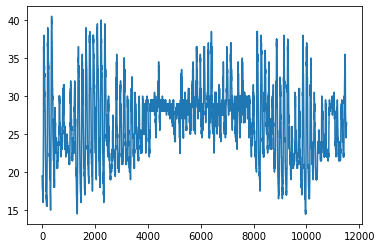

In [119]:
y_pred_result = ((Y_pred*2).astype('int32'))/2

plt.plot(y_pred_result)

y_pred_result = pd.DataFrame(y_pred_result, index = test_dt.index, columns = ['Y18'])

In [0]:
y_pred_result.to_csv('/content/gdrive/My Drive/Colab Notebooks/y_pred_result.csv')

In [0]:
def data_processing(X_data):
  X_data['X01'] = X_data[['X01','X06']].mean(axis = 1)
  X_data['X22'] = X_data[['X22','X29']].mean(axis = 1)
  X_data['X05'] = X_data[['X05','X08','X09','X23','X33']].mean(axis = 1)
  X_data['X11'] = X_data[['X11','X34']].mean(axis = 1)
  # 13 삭제 / 14,16,19 0 값 삭제
  X_data = X_data.drop(['X06','X29','X08','X09','X23','X33','X34','X13','X14','X16','X19'], axis = 1)
  return X_data

In [0]:
test_dt.head()

,X00,X02,X03,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X24,X25,X26,X27,X29,X30,X34,X35,X36,X37,X38,X39
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4752,19.94,1.5,1.3,0.0,0.0,96.1,333.6,0.0,199.6,0.0,36.0,1.1,0.0,94.7,0.0,1000.3,0.0,0.0,0.1,1006.0,999.5,91.4,0.0,194.7,0.0,84.0,59.9,0.0
4753,19.92,1.1,1.2,0.0,0.0,96.2,335.5,0.0,194.0,0.0,127.7,0.6,0.0,95.3,0.0,1000.2,0.0,0.0,0.3,1005.9,999.4,91.6,0.0,173.1,0.0,84.0,60.5,0.0
4754,19.90,1.3,1.2,0.0,0.0,96.4,0.0,0.0,172.9,0.0,59.0,0.0,0.0,93.9,0.0,1000.1,0.0,0.0,0.7,1005.9,999.3,92.0,0.0,208.6,0.0,85.0,60.8,0.0
4755,19.72,2.3,0.8,0.0,0.0,96.5,252.9,0.0,153.5,0.0,54.9,0.4,0.0,94.4,0.0,1000.1,0.0,0.0,0.6,1005.8,999.3,93.0,0.0,185.0,0.0,85.8,61.2,0.0
4756,19.68,1.1,0.7,0.0,0.0,96.6,238.2,0.0,173.8,0.0,48.8,0.8,0.0,95.7,0.0,1000.2,0.0,0.0,0.7,1005.9,999.2,92.3,0.0,162.8,0.0,87.3,61.7,0.0


In [0]:
Y_pred = predict_test(X_train, Y_train, test_dt)

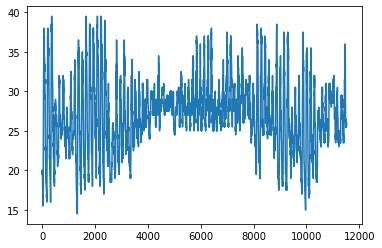

In [0]:
y_pred_result = ((Y_pred*2).astype('int32'))/2

plt.plot(y_pred_result)

y_pred_result = pd.DataFrame(y_pred_result, index = test_dt.index, columns = ['Y18'])

In [0]:
y_pred_result.to_csv('/content/gdrive/My Drive/Colab Notebooks/y_pred_result.csv')

In [0]:
X_train = train_dt.iloc[:,:-19]

In [0]:
Y_train = train_dt_j['Y18']

In [0]:
X_test = test_dt

In [0]:
Y_pred = predict_test(X_train, Y_train, X_test)

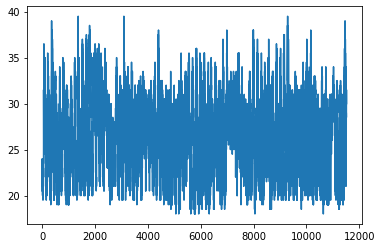

In [0]:
y_pred_result = ((Y_pred*2).astype('int32'))/2

plt.plot(y_pred_result)

y_pred_result = pd.DataFrame(y_pred_result, index = test_dt.index, columns = ['Y18'])

In [0]:
y_pred_result.to_csv('/content/gdrive/My Drive/Colab Notebooks/y_pred_result.csv')

In [0]:
X_train = train_dt.iloc[:,:-19]
X_train = data_processing(X_train)

X_train.head()

,X00,X01,X02,X03,X04,X05,X07,X10,X11,X12,X15,X17,X18,X20,X21,X22,X24,X25,X26,X27,X28,X30,X31,X32,X35,X36,X37,X38,X39
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,9.7,989.20,1.2,0.6,0.0,1009.78,12.2,0.0,0.0,82.4,101.1,56.1,0.3,91.0,0.0,1002.05,1.1,2.3,0.5,1008.7,12.3,69.1,8.2,10.7,256.4,0.0,77.2,62.6,0.0
1,9.3,989.25,1.7,1.9,0.0,1009.84,12.1,0.0,0.0,81.2,165.3,0.0,0.4,91.9,0.0,1002.10,0.0,0.0,0.0,1008.7,12.1,70.3,8.3,10.3,215.4,0.0,77.3,63.5,0.0
2,9.4,989.35,1.1,2.3,0.0,1009.84,12.1,0.0,0.0,86.1,144.0,0.0,0.6,93.3,0.0,1002.00,0.0,0.0,0.0,1008.6,12.1,71.5,8.0,9.7,235.2,0.0,77.3,63.9,0.0
3,9.4,989.25,1.5,0.7,0.0,1009.80,12.0,0.0,0.0,87.7,115.9,294.1,0.1,93.4,0.0,1001.95,0.0,0.0,0.2,1008.7,12.1,73.2,7.7,9.4,214.0,0.0,77.5,64.5,0.0
4,9.2,989.30,0.8,1.7,0.0,1009.82,12.0,0.0,0.0,88.9,124.7,0.0,0.0,94.1,0.0,1001.95,0.0,0.0,0.0,1008.7,12.0,74.3,7.4,9.4,174.9,0.0,78.0,65.0,0.0


In [0]:
# 4300개의 예측값(12,16 평균) + Y_의 실제값
before = train_dt[['Y12','Y09','Y16','Y06']].iloc[:-432].mean(axis = 1)
# after = main[[18]].mean(axis = 1)
after = train_dt.iloc[4320:,-1]

Y_train = pd.concat([before, after],ignore_index=True)

Y_train.head()

0    8.500
1    8.000
2    7.750
3    7.625
4    7.375
dtype: float64

In [0]:
X_test = data_processing(test_dt)
X_test.head()

,X00,X01,X02,X03,X04,X05,X07,X10,X11,X12,X15,X17,X18,X20,X21,X22,X24,X25,X26,X27,X28,X30,X31,X32,X35,X36,X37,X38,X39
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4752,18.7,987.68125,1.5,1.3,0.0,1007.47392,21.1,0.0,0.0,96.1,199.6,36.0,1.1,94.7,0.0,999.5500,0.0,0.0,0.1,1006.0,23.2,91.4,17.5,19.2,194.7,0.0,84.0,59.9,0.0
4753,18.8,987.68125,1.1,1.2,0.0,1007.42384,21.2,0.0,0.0,96.2,194.0,127.7,0.6,95.3,0.0,999.4500,0.0,0.0,0.3,1005.9,23.1,91.6,17.4,19.1,173.1,0.0,84.0,60.5,0.0
4754,19.0,987.58750,1.3,1.2,0.0,1007.37376,21.2,0.0,0.0,96.4,172.9,59.0,0.0,93.9,0.0,999.3500,0.0,0.0,0.7,1005.9,23.1,92.0,17.2,19.0,208.6,0.0,85.0,60.8,0.0
4755,18.7,987.58750,2.3,0.8,0.0,1007.34880,21.1,0.0,0.0,96.5,153.5,54.9,0.4,94.4,0.0,999.3500,0.0,0.0,0.6,1005.8,22.8,93.0,17.2,18.8,185.0,0.0,85.8,61.2,0.0
4756,18.4,987.68125,1.1,0.7,0.0,1007.37392,20.9,0.0,0.0,96.6,173.8,48.8,0.8,95.7,0.0,999.2625,0.0,0.0,0.7,1005.9,22.8,92.3,17.4,18.9,162.8,0.0,87.3,61.7,0.0


In [0]:
Y_pred = predict_test(X_train, Y_train, X_test)

cv start
[10]	cv_agg's l1: 4.25489 + 0.0694901
[20]	cv_agg's l1: 2.70545 + 0.0571609
[30]	cv_agg's l1: 1.822 + 0.045832
[40]	cv_agg's l1: 1.32618 + 0.0347769
[50]	cv_agg's l1: 1.05179 + 0.0322642
[60]	cv_agg's l1: 0.89862 + 0.0272574
[70]	cv_agg's l1: 0.813404 + 0.024566
[80]	cv_agg's l1: 0.757922 + 0.0232371
[90]	cv_agg's l1: 0.719994 + 0.0212905
[100]	cv_agg's l1: 0.692506 + 0.0208322
[110]	cv_agg's l1: 0.671952 + 0.0193596
[120]	cv_agg's l1: 0.655202 + 0.0179964
[130]	cv_agg's l1: 0.643693 + 0.0182114
[140]	cv_agg's l1: 0.633316 + 0.0177961
[150]	cv_agg's l1: 0.623882 + 0.0170327
[160]	cv_agg's l1: 0.615725 + 0.0167813
[170]	cv_agg's l1: 0.607173 + 0.0169768
[180]	cv_agg's l1: 0.599813 + 0.0168939
[190]	cv_agg's l1: 0.593347 + 0.0163874
[200]	cv_agg's l1: 0.587489 + 0.016507
[210]	cv_agg's l1: 0.58177 + 0.0162884
[220]	cv_agg's l1: 0.576665 + 0.0158907
[230]	cv_agg's l1: 0.571917 + 0.0155628
[240]	cv_agg's l1: 0.567804 + 0.0147679
[250]	cv_agg's l1: 0.563948 + 0.0146783
[260]	cv_agg

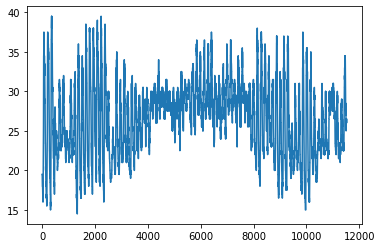

In [0]:
y_pred_result = ((Y_pred*2).astype('int32'))/2

plt.plot(y_pred_result)

y_pred_result = pd.DataFrame(y_pred_result, index = test_dt.index, columns = ['Y18'])

In [0]:
y_pred_result.to_csv('/content/gdrive/My Drive/Colab Notebooks/y_pred_result.csv')

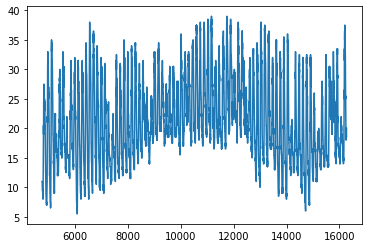

In [0]:
plt.plot(y_pred_result)
